<h1>Gradient Descent</h1>

In my notes on neural networks, I realized that I haven't given much justice to describing gradient descent. So, I decided to create a separate notebook where I describe gradient descent and its many variations.

<h2>Concept</h2>

The concept behind gradient descent is that given a convex functions (where the global minima are the local minima), we can find the minimum iteratively by computing the *gradient* of that function at specific points. Given a cost function, $J$, we can minimize it using the equation:

$$w \rightarrow w' = w - \eta \nabla_w J(x) $$

where $w$ is a column vector of weights and $x$ is a column vector of the input features. $\eta$ is a learning rate which is a hyperparameter that we adjust. Let's assume we have an equation of the form:

$$w_1x_1 + w_2x_2 + ... + w_n = w^Tx$$

(the last entry in the vector $x$ is 1). Then, given an appropriate cost function, we can find the vector $w$ such that $w^Tx = \hat{y} \approx y$. For now, we will define the cost function as the mean-squared error (MSE) function:

$$J(x) = \frac{1}{2n} \sum_{i=1}^n \parallel \hat{y}^i - y^i \parallel^2 = \frac{1}{2n} \sum_{i=1}^n \parallel w^Tx^i - y^i \parallel^2$$

where $n$ is the number of examples. The entries for the gradient of this function $\nabla_w J(x)$ is:

$$\frac{\partial J}{\partial w_j} = \frac{1}{n} \sum_{i=1}^{n} (\hat{y}^i - y^i)x^i_j$$

<h2>Example</h2>

In order to demonstrate gradient descent, let's create some sample data and then write the gradient descent algorithm. First, let's write the boilerplate to generate the sample data:


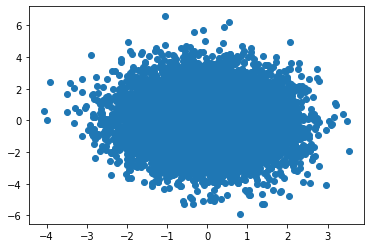

In [186]:
import time
import numpy as np
import matplotlib.pyplot as plt

def generate_rand_func(n: int, d: int):
    x = np.random.randn(n, d, 1)
    w = np.random.randn(d, 1)
    y = np.dot(w.T, x)
    return (y.reshape(n, 1), x, w)

def cost(y, w, x):
    return sum([ np.linalg.norm((np.dot(w.T, x[i]) - y[i, 0]))**2 for i in range(0, x.shape[0]) ]) / (2*x.shape[0])

(y, x, w) = generate_rand_func(10000, 2)
plt.scatter(x[:, 0], y)

The above generates some data and then graphs it. As you can see, there's a strong linear correlation in the data. Note that in this case, I'm going to assume (for simplicity) that y is a scalar (or $1 \text{x} 1$ vector). This doesn't change the implementation too much, but it makes things easier to think about. Now, we implement *batch gradient descent*, which operates on the entire dataset:

Took 14.400641280000855 seconds
J(x) = 0.00010134414563189352


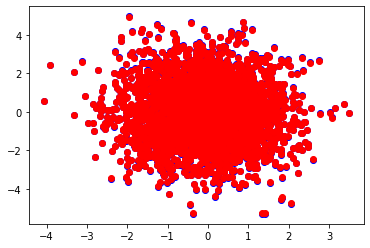

In [259]:
def gradient_descent(y, x, eta: float, niters: int):
    (n, d) = (x.shape[0], x.shape[1])
    w = np.random.randn(d, 1)
    for m in range(0, niters):
        nabla_J = np.zeros((d, 1), dtype=float)
        for j in range(0, nabla_J.shape[0]):
            s = 0.0
            for i in range(0, n):
                s += (np.dot(w.T, x[i]) - y[i, 0]) * x[i, j]
            nabla_J[j, 0] = s/n
        w = w - eta * nabla_J
    return w

def test_gradient_descent():
    split = int(0.7*x.shape[0])
    start = time.perf_counter()
    w = gradient_descent(y[:split], x[:split], 0.05, 100)
    end = time.perf_counter()
    plt.scatter(x[split:, 0], y[split:], c='b') # Test data: blue
    plt.scatter(x[split:, 0], [np.dot(w.T, x[i]) for i in range(split, x.shape[0])], c='r') # Predictions: red
    print('Took {} seconds'.format(end-start))
    print('J(x) = {}'.format(cost(y, w, x)))

test_gradient_descent()

Not bad! It might not be obvious at first, but if you look at the graph, the blue dots (test data) and red dots (predictions on the test data) match up pretty well! However, there is still a lot left to be desired
with this implementation. On my machine, the above took almost 20 seconds to run! We can vectorize the above implementation so that we don't have to use for loops. This will save us some time in the long run. Let's try that out.

Took 0.13465247500062105 seconds
J(x) = 5.6024139844450647e-05


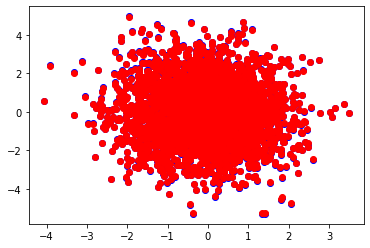

In [258]:
def gradient_descent(y, x, eta: float, niters: int):
    (n, d) = (x.shape[0], x.shape[1])
    w = np.random.randn(d, 1)
    for m in range(0, niters):
        w = w - eta * np.sum((w.T @ x - y.reshape(n, 1, 1)) * x, axis=0) / n
    return w

test_gradient_descent()

This is an order of magnitude better. But the algorithm can still be improved. We can actually reduced the parameters we give to the `gradient_descent` function. The `niters` parameter specifies the number of
steps to make. By treating this as a hyperparameter, we risk taking unnecessary steps. This is an easy fix. Let $\hat{w}_1$ be the predicted weight vector after the $k^{th}$ iteration and $\hat{w}_2$ be the predicted weight
vector after the $(k+1)^{th}$ iteration. Thus, we can say: 

$$\parallel \hat{w}_2 - \hat{w}_1 \parallel < \epsilon$$

where $\epsilon$ is a small positive real number that indicates the acceptable difference between $\hat{w}_2$ and $\hat{w}_1$. If the difference between the two is small enough, we can stop the algorithm
since further changes won't affect the difference. Let's rewrite the functions:


Took 0.09126101299989386 seconds
J(x) = 1.7834444291190666e-08


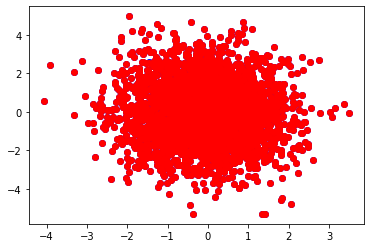

In [263]:
def gradient_descent(y, x, eta: float):
    (n, d) = (x.shape[0], x.shape[1])
    w = np.random.randn(d, 1)
    w_prev = None
    epsilon = 1e-5
    while True:
        w_prev = w
        w = w - eta * np.sum((w.T @ x - y.reshape(n, 1, 1)) * x, axis=0) / n
        if w_prev is not None and np.linalg.norm(w-w_prev) < epsilon:
            break
    return w

def test_gradient_descent():
    split = int(0.7*x.shape[0])
    start = time.perf_counter()
    w = gradient_descent(y[:split], x[:split], 0.05) # No more niters
    end = time.perf_counter()
    plt.scatter(x[split:, 0], y[split:], c='b') # Test data: blue
    plt.scatter(x[split:, 0], [np.dot(w.T, x[i]) for i in range(split, x.shape[0])], c='r') # Predictions: red
    print('Took {} seconds'.format(end-start))
    print('J(x) = {}'.format(cost(y, w, x)))

test_gradient_descent()